# Real Data Example

Trey V. Wenger (c) November 2024

Here we demonstrate the basic `amoeba2` workflow applied to some real OH absorption data.

In [1]:
# General imports    
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pytensor
print("pytensor version:", pytensor.__version__)

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.26.3
pymc version: 5.18.2
bayes_spec version: 1.7.2
amoeba2 version: 1.0.1+7.gad490bf.dirty


## Load the Data

Our data are stored in a pickle file.

In [2]:
import pickle

with open("example_data.pkl", "rb") as f:
    real_data = pickle.load(f)
    
print(real_data.keys())

dict_keys(['coord', 'velocity_1612', 'absorption_1612', 'velocity_1665', 'absorption_1665', 'velocity_1667', 'absorption_1667', 'velocity_1720', 'absorption_1720'])


We pack the data into a `SpecData` dictionary.

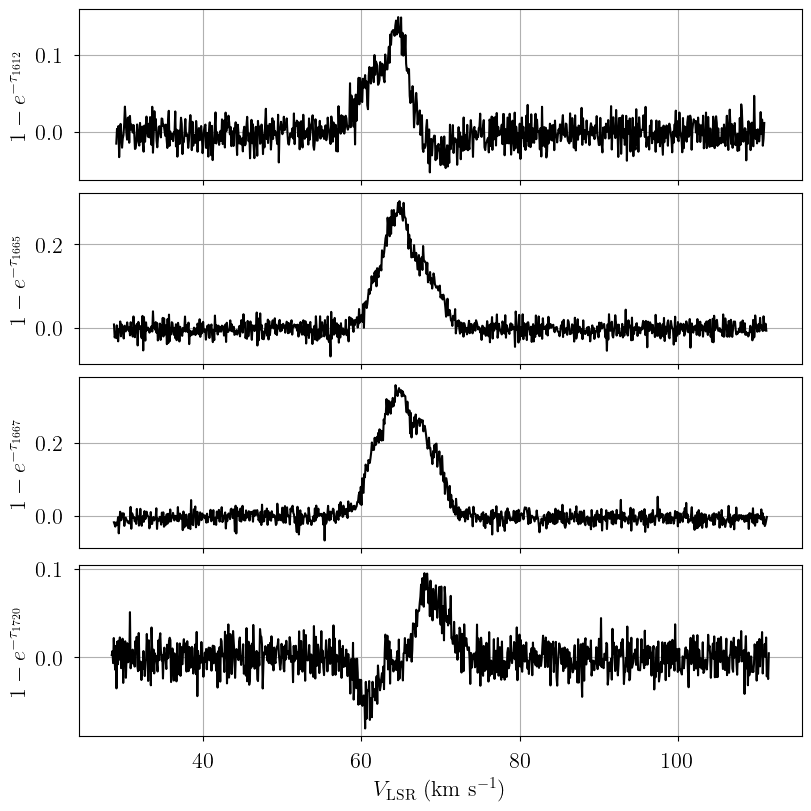

In [8]:
from bayes_spec import SpecData

data = {}
for transition in ["1612", "1665", "1667", "1720"]:
    # estimate rms
    med = np.median(real_data[f"absorption_{transition}"])
    rms = 1.4826 * np.median(np.abs(real_data[f"absorption_{transition}"] - med))
    data[f"absorption_{transition}"] = SpecData(
        real_data[f"velocity_{transition}"],
        real_data[f"absorption_{transition}"],
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{transition}"+r"}}$"
    )

# Plot the data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Optimization

Now we determine the optimal number of clouds using the `AbsorptionModel`. It seems that the baselines are well-behaved, so we set `baseline_degree=0`. We update the velocity and rms priors to something reasonable for these data.

In [11]:
from bayes_spec import Optimize
from amoeba2 import AbsorptionModel

# Initialize optimizer
opt = Optimize(
    AbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=8,  # maximum number of clouds
    baseline_degree=0,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_tau = [0.1, 0.1], # mean and width of log10(tau) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [70.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
opt.add_likelihood()

We will assume that we have thoroughly tested our model and determined effective VI and MCMC hyperparameters for our data. Below we use the same values as in the other tutorials, but this is just for demonstration. You should test these hyperparameters carefully. Now we sample every model with MCMC.

In [12]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "tune": 1000,
    "draws": 1000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=False)

Null hypothesis BIC = 7.341e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = -4,787.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.


Adding log-likelihood to trace


Output()

There were 26 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.833e+04

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = -5,900.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 503 seconds.


Adding log-likelihood to trace


Output()

There were 112 divergences in converged chains.
GMM converged to unique solution
3 of 4 chains appear converged.
n_cloud = 2 solution = 0 BIC = -1.971e+04

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = -6,654.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 453 seconds.


Adding log-likelihood to trace


Output()

There were 212 divergences in converged chains.
GMM converged to unique solution
2 of 4 chains appear converged.
n_cloud = 3 solution = 0 BIC = -1.991e+04

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = -6,775.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 255 seconds.


Adding log-likelihood to trace


Output()

There were 68 divergences in converged chains.
GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.999e+04

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = -6,864.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 288 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -1.999e+04

Sampling n_cloud = 6 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = -7,458.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 365 seconds.


Adding log-likelihood to trace


Output()

There were 41 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.

Sampling n_cloud = 7 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = -7,540.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 534 seconds.


Adding log-likelihood to trace


Output()

There were 55 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.

Sampling n_cloud = 8 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4100
Interrupted at 4,099 [4%]: Average Loss = -7,478.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, tau_1612_norm, tau_1665_norm, tau_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 787 seconds.


Adding log-likelihood to trace


Output()

There were 12 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.



In [13]:
az.summary(opt.best_model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_1612_norm[0],-0.230,0.021,-0.268,-0.189,0.000,0.000,2744.0,2465.0,1.00
baseline_absorption_1665_norm[0],-0.352,0.011,-0.373,-0.332,0.000,0.000,1903.0,2553.0,1.00
baseline_absorption_1667_norm[0],-0.377,0.009,-0.393,-0.361,0.000,0.000,2451.0,1897.0,1.00
baseline_absorption_1720_norm[0],-0.063,0.029,-0.117,-0.009,0.001,0.001,1606.0,668.0,1.00
tau_1612_norm[0],2.969,0.388,2.270,3.743,0.011,0.008,1100.0,1406.0,1.00
tau_1612_norm[1],-2.222,0.151,-2.519,-1.953,0.003,0.002,2034.0,1596.0,1.00
tau_1612_norm[2],-0.678,0.615,-1.871,0.413,0.021,0.015,860.0,1229.0,1.00
tau_1612_norm[3],1.984,0.418,1.264,2.746,0.015,0.011,863.0,1109.0,1.00
log10_depth_norm[0],0.181,0.628,-1.055,1.305,0.019,0.013,1102.0,1371.0,1.00
log10_depth_norm[1],1.266,0.624,0.043,2.414,0.026,0.018,679.0,265.0,1.00


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720]


Output()

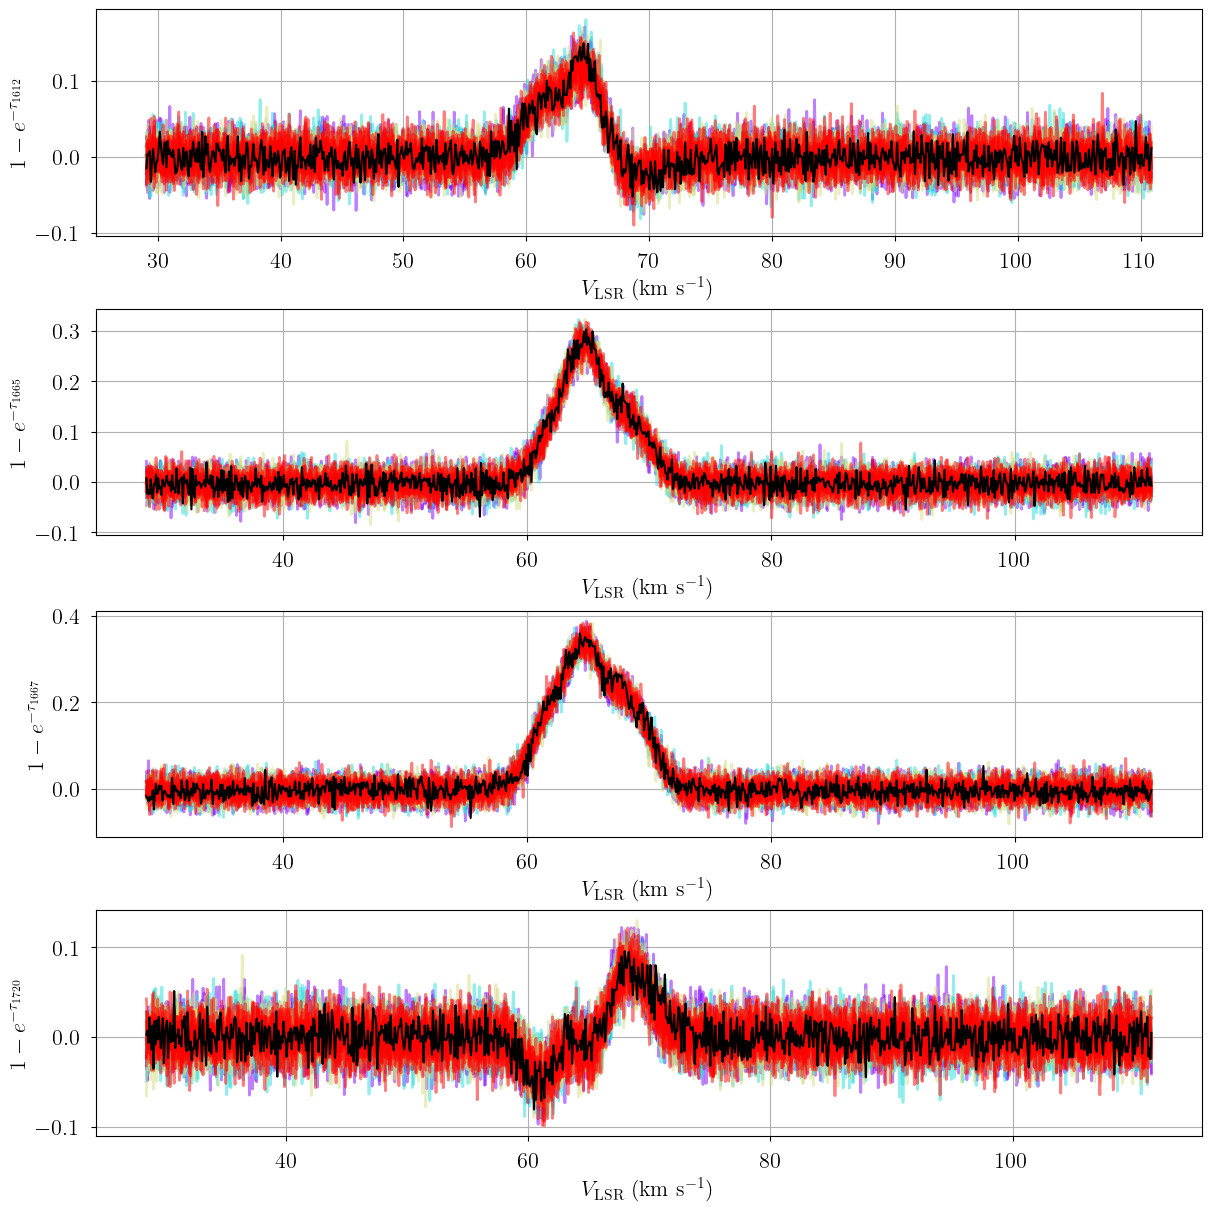

In [14]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

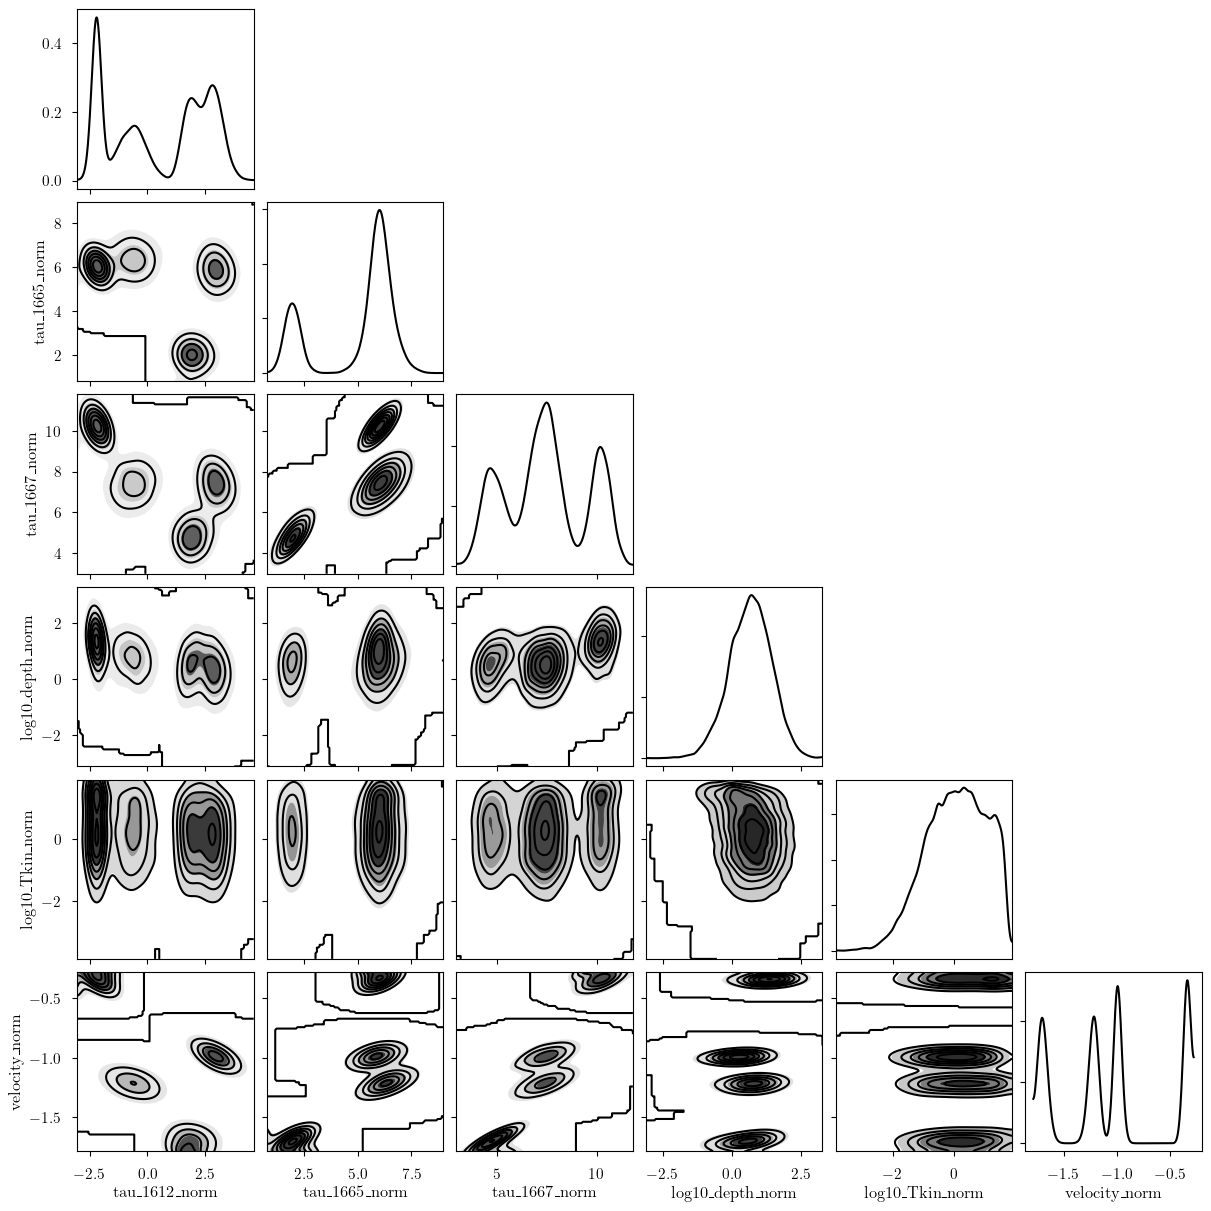

In [15]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    opt.best_model.trace.solution_0, # samples
    opt.best_model.cloud_freeRVs, # var_names to plot
    labeller=opt.best_model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)